Based on the following links to create this notebook:

https://colab.research.google.com/drive/18LdlDDT87eb8cCTHZsXyS9ksQPzL3i6H

https://colab.research.google.com/drive/1tug_bpg8RwrFOI8C6Ed-zo0OgD3yfnWy#scrollTo=bhsj7BTPHepg

https://colab.research.google.com/drive/1tug_bpg8RwrFOI8C6Ed-zo0OgD3yfnWy


To run Gym, you have to install prerequisites like xvbf,opengl & other python-dev packages using the following codes.

In [ ]:
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 0s (5,230 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 160975 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 784 kB o

In [ ]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
import numpy as np
import random as rnd
from math import exp
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from collections import deque, namedtuple
from IPython import display as ipythondisplay
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.optim import Adam
from datetime import datetime

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [ ]:
!pip install gym[box2d]

     |████████████████████████████████| 450kB 10.6MB/s 


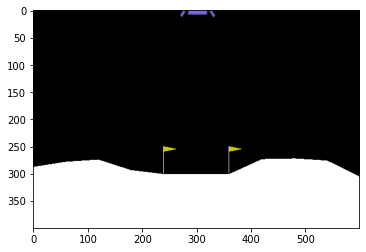

In [ ]:
# Box2d Environment
env = gym.make('LunarLanderContinuous-v2')
env.reset()
plt.imshow(env.render('rgb_array'))


In [ ]:
state_size = env.observation_space
print("state size is:", state_size)
a = env.action_space
print("action size=",a) 
state = env.reset()
print(state)   

state size is: Box(-inf, inf, (8,), float32)
action size= Box(-1.0, 1.0, (2,), float32)
[-4.8828126e-05  1.4078301e+00 -4.9733138e-03 -1.3733506e-01
  6.3490952e-05  1.1265365e-03  0.0000000e+00  0.0000000e+00]


# Action Space
            #is two floats [main engine, left-right engines].
            # Main engine: -1..0 off, 0..+1 throttle from 50% to 100% power. Engine can't work with less than 50% power.
            # Left-right:  -1.0..-0.5 fire left engine, +0.5..+1.0 fire right engine, -0.5..0.5 off
            self.action_space = spaces.Box(-1, +1, (2,), dtype=np.float32)

# **Model DQN**

In [ ]:

class DQN(nn.Module):
    """
    | DQN model with cusomize layers contains only fully connected layers with relu function
    """
    def __init__(self, input_dim, output_dim, hid_dim=(256, 256, 256)):
        super(DQN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hid_dim
        self.layers = nn.ModuleList()
        current_dim = input_dim
        for dim in hid_dim:
            self.layers.append(nn.Linear(current_dim, dim))
            current_dim = dim
        self.output_layer = nn.Linear(current_dim, output_dim)

    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
        return self.output_layer(x)


#**Model Dueling DQN**

In [ ]:
from torch import nn


class DuelingDQN(nn.Module):
    """
    | Dueling DQN model with fully connected layers
    """
    def __init__(self, input_dim, output_dim):
        super(DuelingDQN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.feat_fc = nn.Sequential(
            nn.Linear(self.input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )

        self.value_fc = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.adv_fc = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, self.output_dim)
        )

    def forward(self, x):
        x = self.feat_fc(x)
        values = self.value_fc(x)
        advantages = self.adv_fc(x)
        return values + (advantages - advantages.mean())

# **Replay Memory**

In [ ]:
Experience = namedtuple('Experience',
                        ('state', 'action', 'next_state', 'reward'))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import random as rnd
from collections import namedtuple, deque

import torch

Experience = namedtuple('Experience',
                        ('state', 'action', 'next_state', 'reward'))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class ReplayMemory(object):
    """
    | replay memory to store the expririence for using in learning algorithm
    """
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)
        self.position = 0

    def push(self, *args):
        """
        update memory queue
        """
        self.position += 1
        self.memory.append(Experience(*args))

    def sample(self, batch_size):
        """
        | take sample in uniform way
        """
        data = rnd.sample(self.memory, batch_size)
        data = Experience(*zip(*data))
        return (torch.cat(data.state).to(device),
                torch.cat(data.action).to(device),
                torch.cat(data.next_state).to(device),
                torch.cat(data.reward).to(device))

    def can_provide_sample(self, batch_size):
        """
        | validate that we have enough samples to learn
        """
        return self.position >= batch_size


# **Prioritized experience replay**

In [ ]:
import random as rnd
from collections import namedtuple, deque
import numpy as np
import torch

Experience = namedtuple('Experience',
                        ('state', 'action', 'next_state', 'reward'))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class ReplayMemoryPER(object):
    # # beta_increment_per_sampling = 1.001
    # # alpha_decay = 0.99
    # beta = 0.5
    # beta_increment_per_sampling = 0.001
    # alpha = 0.5
    # alpha_decay = 0.01

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)
        self.prioritize = deque(maxlen=capacity)
        self.position = 0

    def push(self, *args):
        """
        update memory queue
        :param args:
        :return:
        """
        self.position += 1
        self.memory.append(Experience(*args))
        self.prioritize.append(max(self.prioritize, default=1))

    def get_probability(self):
        """
        calculate probability to get choosen
        :return:
        """
        scaled_priority = np.array(self.prioritize) ** 0.6
        return scaled_priority / sum(scaled_priority)

    def sample(self, batch_size):
        """
        | take sample based on importance weight randomization
        """
        sample_prob = self.get_probability()
        indexes = rnd.choices(range(len(self.memory)), k=batch_size, weights=list(sample_prob))
        data = np.array(self.memory)[indexes]
        importance = self.get_importance(sample_prob[indexes])
        data = Experience(*zip(*data))
        return (torch.cat(data.state).to(device),
                torch.cat(data.action).to(device),
                torch.cat(data.next_state).to(device),
                torch.cat(data.reward).to(device)), \
                importance, indexes

    def get_importance(self, prob):
        """
        getting sample importance
        """
        importance = (1 / self.capacity * 1 / prob)**0.5
        return importance

    def can_provide_sample(self, batch_size):
        """
        | validate that we have enough samples to learn
        """
        return self.position >= batch_size

    def set_priority(self, indices, errors, offset=1e-6):
        """
        update priority for samples
        """
        for i, e in zip(indices, errors):
            self.prioritize[i] = abs(e) + offset


# **Agent**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 0.01
LR = 0.0005
TARGET_UPDATE = 4
EPS_START = 0.99
EPS_END = 0.01
EPS_DECAY = 0.01


class Agent(object):
    """
    agent for choosing next step based on strategy
    converting action to discrete value
    update Q-values
    save model
    update target model
    """
    def __init__(self, state_size, actions, model, strategy, full_model_name, loss="mse"):
        self.strategy = eval("self." + strategy)
        self.state_size = state_size
        self.action_size = len(actions)
        self._model = full_model_name
        self._step = 0
        self._actions = actions
        self._memory = ReplayMemory(10000)
        self.loss = F.mse_loss if loss == "mse" else F.smooth_l1_loss
        self._policy_net = eval(model)(state_size, self.action_size).to(device)
        self._target_net = eval(model)(state_size, self.action_size).to(device)
        self._optimizer = optim.Adam(self._policy_net.parameters(), lr=LR)
        self._mu = 0  # Mean
        self._sigma = 0.05  # Std

    def step(self, state, action, next_state, reward):
        """
        add memory to queue
        :param state: state of actor
        :param action: action which was made
        :param next_state: next step which the actor was moved
        :param reward: reward according to state and action
        """
        self._memory.push(torch.tensor([state]).to(device),
                          torch.tensor([action]).long().to(device),
                          torch.tensor([next_state]).to(device),
                          torch.tensor([reward]).float().to(device))
        self._step = (self._step + 1) % TARGET_UPDATE
        # update each TARGET_UPDATE step
        if self._step == 0:
            if self._memory.can_provide_sample(BATCH_SIZE):
                self.update_q_values()

    def select_step(self, state, eps):
        """
        Choosing next step based on strategy and epsilon
        :param state: current state
        :param eps: epsilon for choosing step
        :return:
        """
        return self.strategy(state, eps)

    def add_noise(self):
        """
        adding noise if configured
        :return: gaussian noise
        """
        return np.random.normal(self._mu, self._sigma, 2)

    def soft_epsilon(self, state, eps):
        """
        soft epsilon strategy choose by using model or choose by random
        actions with weights which was given by model
        :param state: current state
        :param eps: epsilon threshold
        """
        if rnd.uniform(0, 1) > eps:
            with torch.no_grad():
                action_index = self._policy_net(torch.tensor(state).to(device)).argmax().item()
            self._policy_net.train()
            return action_index
        self._policy_net.eval()
        with torch.no_grad():
            weights = F.softmax(self._policy_net(torch.tensor(state).to(device)), dim=0)
        self._policy_net.train()
        return rnd.choices(np.arange(self.action_size), weights, k=1)[0]

    def greedy_epsilon(self, state, eps):
        """
        greedy policy choose action based on model or random action uniformly
        :param state: current state
        :param eps: epsilon threshold
        """
        self._policy_net.eval()
        if rnd.uniform(0, 1) > eps:
            with torch.no_grad():
                action_index = self._policy_net(torch.tensor(state).to(device)).argmax().item()
            self._policy_net.train()
            return action_index
        else:
            return rnd.choice(np.arange(self.action_size))

    def action_index_to_value(self, act):
        """
        convert result from model to discrete action
        """
        return self._actions[act]

    def update_q_values(self):
        """
        update q-values of policy model
        :return:
        """
        if not self._memory.can_provide_sample(BATCH_SIZE):
            return
        states, actions, next_states, rewards = self._memory.sample(BATCH_SIZE)
        next_q, cur_q = self.get_q_values(states, next_states, actions)
        target_q = next_q * GAMMA + rewards

        loss = self.loss(cur_q, target_q.unsqueeze(-1))
        self._optimizer.zero_grad()
        loss.backward()
        self._optimizer.step()
        self.soft_update()

    def get_q_values(self, states, next_states, actions):
        """
        calculate q-values
        :param states: states from memory sample
        :param next_states: next states from memory sample
        :param actions: actions from memory sample
        """
        final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        non_final_states_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_states_locations]
        values = torch.zeros(BATCH_SIZE).float().to(device)
        with torch.no_grad():
            if self._model in ['DDQN', 'DuelingDDQN']:
                next_actions = self._policy_net(non_final_states).argmax(-1, keepdim=True)
                values[non_final_states_locations] = self._target_net(non_final_states).gather(-1,
                                                                                               next_actions).squeeze(-1)
            else:
                values[non_final_states_locations] = self._target_net(non_final_states).max(dim=1)[0]
        return values, self._policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))

    def soft_update(self):
        """
        update the model softly by configuring TAU value
        In case TAU equals 1 then it's hard update
        :return:
        """
        for target_param, local_param in zip(self._target_net.parameters(), self._policy_net.parameters()):
            target_param.data.copy_(TAU * local_param.data + (1.0 - TAU) * target_param.data)

    def save_policy_net(self, name):
        """
        save policy model
        :param name: file name
        """
        torch.save(self._policy_net.state_dict(), name+'.pkl')


In [ ]:



class AgentPER(object):
    """
    Prioritized agent for choosing next step based on strategy
    converting action to discrete value
    update Q-values
    save model
    update target model
    """
    def __init__(self, state_size, actions, model, strategy, full_model_name, loss="mse"):
        self.strategy = eval("self." + strategy)
        self.state_size = state_size
        self.action_size = len(actions)
        self._model = full_model_name
        self._step = 0
        self._actions = actions
        self._memory = ReplayMemoryPER(10000)
        self.loss = F.mse_loss if loss == "mse" else F.smooth_l1_loss
        self._policy_net = eval(model)(state_size, self.action_size).to(device)
        self._target_net = eval(model)(state_size, self.action_size).to(device)
        self._optimizer = optim.Adam(self._policy_net.parameters(), lr=LR)
        self._mu = 0  # Mean
        self._sigma = 0.05  # Std

    def step(self, state, action, next_state, reward):
        """
        add memory to queue
        :param state: state of actor
        :param action: action which was made
        :param next_state: next step which the actor was moved
        :param reward: reward according to state and action
        """
        self._memory.push(torch.tensor([state]).to(device),
                          torch.tensor([action]).long().to(device),
                          torch.tensor([next_state]).to(device),
                          torch.tensor([reward]).float().to(device))
        self._step = (self._step + 1) % TARGET_UPDATE
        if self._step == 0:
            if self._memory.can_provide_sample(BATCH_SIZE):
                self.update_q_values()

    def select_step(self, state, eps):
        """
        Choosing next step based on strategy and epsilon
        :param state: current state
        :param eps: epsilon for choosing step
        :return:
        """
        return self.strategy(state, eps)

    def add_noise(self):
        """
        adding noise if configured
        :return: gaussian noise
        """
        return np.random.normal(self._mu, self._sigma, 2)

    def soft_epsilon(self, state, eps):
        """
        soft epsilon strategy choose by using model or choose by random
        actions with weights which was given by model
        :param state: current state
        :param eps: epsilon threshold
        """
        self._policy_net.eval()
        weights = F.softmax(self._policy_net(torch.tensor(state).to(device)), dim=0)
        self._policy_net.train()
        return rnd.choices(np.arange(self.action_size), weights, k=1)[0]

    def greedy_epsilon(self, state, eps):
        """
        greedy policy choose action based on model or random action uniformly
        :param state: current state
        :param eps: epsilon threshold
        """
        self._policy_net.eval()
        if rnd.uniform(0, 1) > eps:
            with torch.no_grad():
                action_index = self._policy_net(torch.tensor(state).to(device)).argmax().item()
            self._policy_net.train()
            return action_index
        else:
            return rnd.choice(np.arange(self.action_size))

    def action_index_to_value(self, act):
        """
        convert result from model to discrete action
        """
        return self._actions[act]

    def update_q_values(self):
        """
        update q-values of policy model
        :return:
        """
        if not self._memory.can_provide_sample(BATCH_SIZE):
            return
        (states, actions, next_states, rewards), weights, indexes = self._memory.sample(BATCH_SIZE)
        next_q, cur_q = self.get_q_values(states, next_states, actions)
        target_q = next_q * GAMMA + rewards

        loss = self.loss(cur_q, target_q.unsqueeze(-1))
        with torch.no_grad():
            weight = np.multiply(weights, loss.data.cpu().numpy()).mean()
        loss = weight * loss
        self._optimizer.zero_grad()
        loss.backward()
        self._optimizer.step()
        self.soft_update()
        delta = (abs(target_q.detach() - cur_q.squeeze(1).detach())).cpu().numpy()
        self._memory.set_priority(indexes, delta)

    def get_q_values(self, states, next_states, actions):
        """
        calculate q-values
        :param states: states from memory sample
        :param next_states: next states from memory sample
        :param actions: actions from memory sample
        """
        final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        non_final_states_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_states_locations]
        values = torch.zeros(BATCH_SIZE).float().to(device)
        with torch.no_grad():
            if self._model in ['DDQN', 'DuelingDDQN']:
                next_actions = self._policy_net(non_final_states).argmax(-1, keepdim=True)
                values[non_final_states_locations] = self._target_net(non_final_states).gather(-1,
                                                                                               next_actions).squeeze(-1)
            else:
                values[non_final_states_locations] = self._target_net(non_final_states).max(dim=1)[0]
        return values, self._policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))

    def soft_update(self):
        """
        update the model softly by configuring TAU value
        In case TAU equals 1 then it's hard update
        :return:
        """
        for target_param, local_param in zip(self._target_net.parameters(), self._policy_net.parameters()):
            target_param.data.copy_(TAU * local_param.data + (1.0 - TAU) * target_param.data)

    def save_policy_net(self, name):
        """
        save policy model
        :param name: file name
        """
        torch.save(self._policy_net.state_dict(), name + '.pkl')

# **Plots**

In [ ]:
def plot_durations(data, name):
    """
    plot episodes score and average of 100 episodes
    :param data: episodes score
    :param name: plot name to save
    :return:
    """
    fig1 = plt.gcf()
    data = torch.tensor(data, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.plot(data.numpy())
    # Take 100 episode averages and plot them too
    if len(data) >= 100:
        means = data.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    plt.show()
    plt.draw()
    plt.pause(0.0001)  # pause a bit so that plots are updated
    fig1.savefig(name+".png")


def plot_means(data):
    """
    plot mean only graph
    :param data: data to plot
    """
    plt.figure(2)
    plt.clf()
    data = torch.tensor(data, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    if len(data) >= 100:
        means = data.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

# **Quantization**

In [ ]:
def get_engine(size, max_cont_val, min_cont_val):
    """
    get possible values for engine
    :param size: the size of action len
    :param max_cont_val: max continuous value
    :param min_cont_val: min continuous value
    :return: possible discrete values
    """
    min_cat_val = 0
    cont_cat_size = abs(max_cont_val - min_cont_val) / (size - min_cat_val)
    cont_val = [(min_cont_val + (discrete_val - min_cat_val + 1) * cont_cat_size)-cont_cat_size/2
                               for discrete_val in range(size)]
    return cont_val


def get_actions():
    """
    get possible actions by combination engines
    :return:
    """
    return [[x, y] for x in [0]+get_engine(2, 1, 0)
            for y in [0]+get_engine(2, 1, 0.5)+get_engine(2, -0.5, -1)]


# **Train**

In [ ]:
def train(base_model, is_noise, strategy, full_model_name, get_next_step, loss, per):
    """
    main train function with game iteration
    """
    print(f"\n\nCONFIGURATION:\n"
          f"\t\tFULL MODEL NAME: {full_model_name}\n"
          f"\t\tBASE MODEL:{base_model}\n"
          f"\t\tNOISE: {is_noise}\n"
          f"\t\tSTRATEGY: {strategy}\n"
          f"\t\tLOSS: {loss}\n"
          f"\t\tMEMORY INPUT: {get_next_step}\n"
          f"\t\tPRIORITIZED: {per}\n")
    env = gym.make('LunarLanderContinuous-v2')
    env.reset()
    # discrete values for possible actions
    actions = get_actions()
    print(actions)
    # select agent according to prioritized mode
    if per:
        agent = AgentPER(state_size=8 if get_next_step == "single_snap" else 16,
                         actions=actions,
                         model=base_model,
                         strategy=strategy,
                         full_model_name=full_model_name,
                         loss=loss)
    else:
        agent = Agent(state_size=8 if get_next_step == "single_snap" else 16,
                      actions=actions,
                      model=base_model,
                      strategy=strategy,
                      full_model_name=full_model_name,
                      loss=loss)
    start = np.array([0, 0, 0, 0, 0, 0, 0, 0], dtype='float32')
    scores_window = deque(maxlen=100)
    scores = []
    for iteration in range(1000):
        total_reward = 0
        iteration += 1
        done = False
        if get_next_step == "memory_snap":
            state = np.zeros(16, dtype="float32")
            state[:8] = env.reset()
            state[8:] = start.copy()
        else:
            state = env.reset()
        # update epsilon
        new_eps = EPS_END + (EPS_START - EPS_END) * np.exp(-1 * iteration * EPS_DECAY)
        while not done:
            action = agent.select_step(state, new_eps)
            action_value = agent.action_index_to_value(action)
            next_state, reward, done, _ = env.step(action_value)
            # add noise if configured
            if is_noise:
                next_state[:2] += agent.add_noise()
            cur_state = state.copy()
            # in case we use prev states
            if get_next_step == "memory_snap":
                state[14:] = state[12:14]    # prev prev prev prev
                state[12:14] = state[10:12]  # prev prev prev
                state[10:12] = state[8:10]   # prev prev
                state[8:10] = state[:2]      # prev
                state[:8] = next_state
            # in case the state contains only next state
            else:
                state = next_state

            agent.step(cur_state, action, state, reward)
            total_reward += reward
        scores_window.append(total_reward)
        scores.append(total_reward)
        print('\rEpisode {}\tAverage Score: {:.2f} EPS:{}'.format(iteration, np.mean(scores_window), new_eps), end="")
        if iteration % 100 == 0 and iteration > 0 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(iteration, np.mean(scores_window)))
        if np.mean(scores_window) >= 200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(iteration,
                                                                                         np.mean(scores_window)))
            name = f"{full_model_name}_" \
                   f"{get_next_step}_per={per}" \
                   f"loss_{loss}_{strategy}_" \
                   f"is_noise={is_noise}_ep_{iteration}_" \
                   f"{datetime.now().hour}_{datetime.now().minute}"
            plot_durations(scores, name)
            agent.save_policy_net(name)
            break
        agent.soft_update()
    plot_means(scores)

In [ ]:
#Dueling, noise, PER, huber

train(base_model="DuelingDQN",  # can be DQN, DuelingDQN
      is_noise=False,  # True, False
      strategy="greedy_epsilon",  # greedy_epsilon or soft_epsilon
      full_model_name="DuelingDDQN",  # DQN, DDQN, DuelingDDQN
      get_next_step="single_snap",  # memory_snap or single_snap
      loss="mse",  # huber or mse
      per=False)  # Prioritized True or False
